# Histopathologic Cancer Detection

### [https://github.com/rrgrs/cancer-detection](https://github.com/rrgrs/cancer-detection)

## Dataset and Problem Overview

The Kaggle "Histopathologic Cancer Detection" competition dataset is a large and complex collection of high-resolution histopathologic scans of lymph node sections, aimed at the challenge of identifying metastatic cancer through the application of Convolutional Neural Networks (CNNs). Comprising approximately 220,000 training images and a separate test set, each image within this dataset is a digital scan of a lymph node biopsy with a resolution of 96x96 pixels. These images are annotated with binary labels indicating the presence (1) or absence (0) of metastatic tissue, presenting a binary classification problem. The dataset's size and high dimensionality pose a significant challenge in terms of computational resources and the need for sophisticated data preprocessing and augmentation strategies to train effective models. Additionally, the subtle visual differences between positive and negative samples demand highly accurate and sensitive CNN architectures to achieve reliable detection performance. This dataset provides a valuable resource for developing and benchmarking advanced machine learning models aimed at improving the accuracy of cancer diagnosis through automated analysis of histopathologic data.

## Import Files and Load Data

In [1]:
import os
from shutil import unpack_archive
import numpy as np 
import pandas as pd
import cv2
from dotenv import dotenv_values
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from skimage.io import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import optuna
import torch.optim as optim
from torchvision import models

In [31]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

env = dotenv_values()
for k, v in env.items():
    os.environ[k] = v

competition_name = 'histopathologic-cancer-detection'
data_dir = 'data'
zip_file = os.path.join(data_dir,  f'{competition_name}.zip')
train_dir = os.path.join(data_dir, 'train')  # Folder containing training images
test_dir = os.path.join(data_dir, 'test')  # Folder containing test images
labels_csv = os.path.join(data_dir, 'train_labels.csv')

api = KaggleApi()
api.authenticate()

if os.path.isfile(zip_file) == False:
    api.competition_download_files(competition_name, path=data_dir)
    unpack_archive(zip_file, data_dir)

labels = pd.read_csv(labels_csv)

## Exploratory Data Analysis

Performing Exploratory Data Analysis (EDA) on the "Histopathologic Cancer Detection" dataset from Kaggle involves several steps designed to understand the dataset's characteristics, distribution, and challenges before developing Convolutional Neural Networks (CNNs) for cancer detection. Initially, the process starts with visual inspection of the images to identify visual patterns, differences between cancerous and non-cancerous samples, and potential anomalies or outliers. This could involve displaying a sample of images that are labeled as having cancerous tissue alongside those that don’t, to visually assess differences and common features. Histograms of pixel intensity values across the dataset can help in understanding the distribution of the data and guiding preprocessing steps like normalization. Furthermore, calculating and visualizing the balance between the classes (presence vs. absence of cancer) is crucial for identifying any need for data augmentation or rebalancing techniques to prevent model bias. Analyzing correlations between different parts of the images (e.g., color channels, regions within the images) might also provide insights into important features for detecting metastatic cancer. Additionally, exploring augmentation techniques, such as rotations, flips, and zooms on a subset of images, could reveal how changes affect the visual appearance and what might be beneficial for the model to learn. This comprehensive EDA process lays the groundwork for more informed model building, preprocessing, and data augmentation strategies, ultimately aiming to improve the performance of CNNs on this critical task.

In [3]:
# Helper functions

# Function to read and convert images
def read_image(file_id, directory, suffix='tif'):
    filepath = os.path.join(directory, f"{file_id}.{suffix}")
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Pixel intensity distribution for a sample of images
def plot_pixel_distribution(samples, directory):
    pixel_values = []
    for _, row in samples.iterrows():
        img = read_image(row['id'], directory)
        # Normalize and flatten image array, then collect values
        normalized_img = img / 255.0
        pixel_values.append(normalized_img.ravel())
    
    # Convert list of arrays into a single array
    pixel_values = np.concatenate(pixel_values)
    
    # Plot the distribution of pixel values
    sns.histplot(pixel_values, bins=50, kde=True, stat="density")
    plt.title('Average Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')

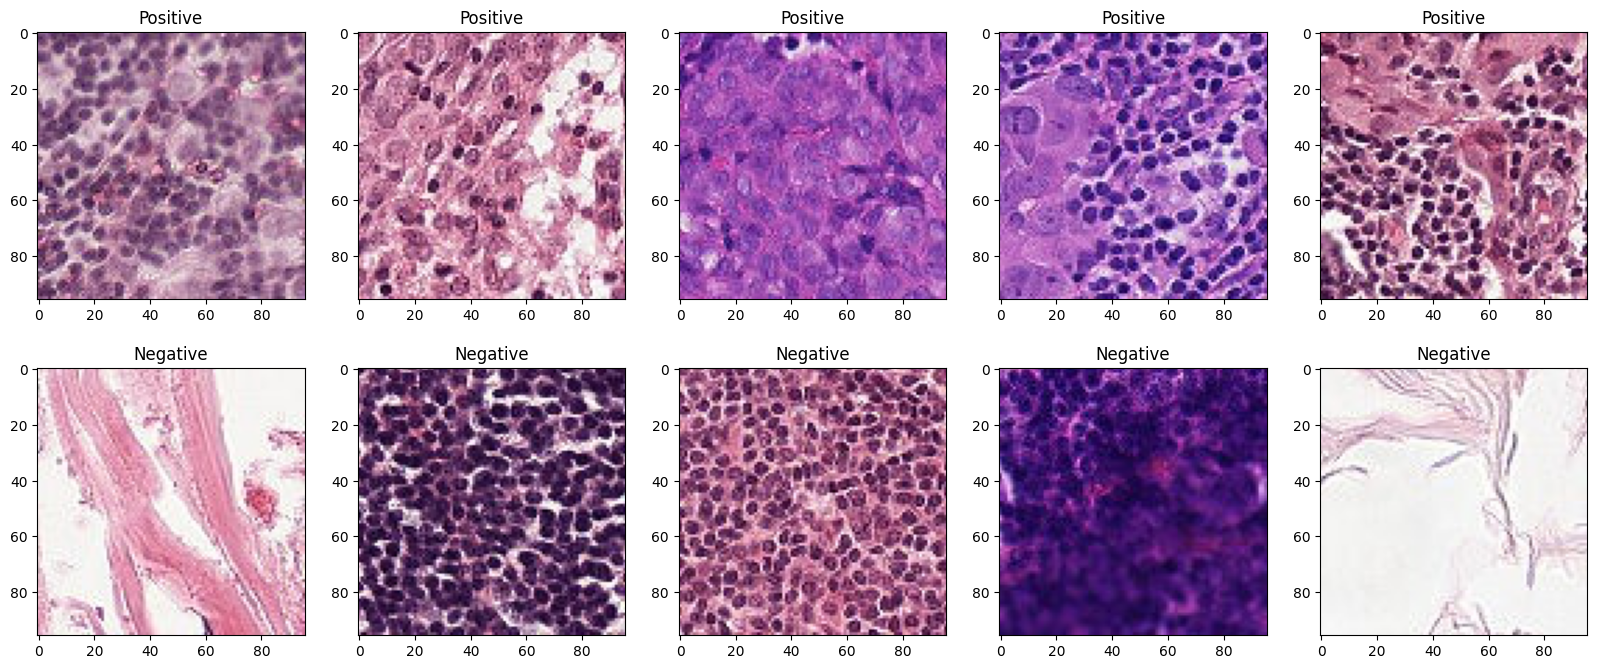

In [4]:
# Sample a few images from each class
sample_positive = labels[labels['label'] == 1].sample(n=5, random_state=42)
sample_negative = labels[labels['label'] == 0].sample(n=5, random_state=42)

# Display sample images
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, (idx, row) in enumerate(sample_positive.iterrows()):
    axs[0, i].imshow(read_image(row['id'], train_dir))
    axs[0, i].set_title("Positive")
for i, (idx, row) in enumerate(sample_negative.iterrows()):
    axs[1, i].imshow(read_image(row['id'], train_dir))
    axs[1, i].set_title("Negative")

Text(0.5, 1.0, 'Class Distribution')

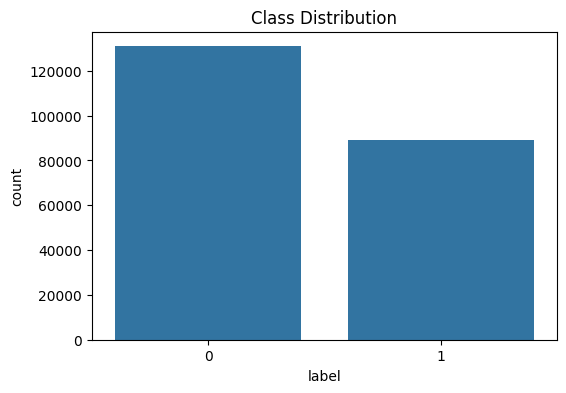

In [5]:
# Show class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')

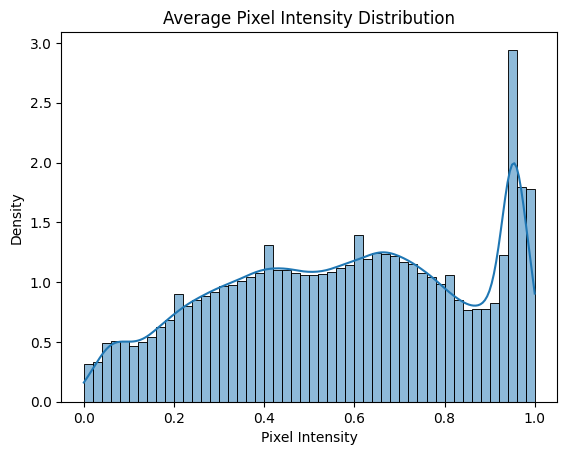

In [6]:
plot_pixel_distribution(pd.concat([sample_positive, sample_negative]), train_dir)

plt.show()

## Data Cleaning

Data cleaning is a pivotal initial step in preparing the "Histopathologic Cancer Detection" dataset for effective model training and analysis. Given the dataset comprises high-resolution histopathologic scans, cleaning may involve several key processes to ensure the data is of high quality and consistency. First, identifying and removing any corrupt or unreadable image files is crucial, as these can introduce noise into the training process. Additionally, it's important to verify the alignment between the image IDs and their corresponding labels in the dataset's CSV file to prevent mislabeling issues. Normalizing the pixel values of the images to a standard scale (e.g., 0 to 1) can help improve model convergence and performance by providing consistency in the input data. Furthermore, data augmentation techniques, while technically part of preprocessing, can also be considered an extension of data cleaning, as they help mitigate the effects of imbalances in the dataset by artificially increasing the variety and quantity of training data. Finally, splitting the dataset into training, validation, and test sets in a stratified manner ensures that each set is representative of the overall distribution of cancerous and non-cancerous samples, facilitating more reliable evaluation and generalization of the model. Through these meticulous data cleaning and preparation steps, the foundation is laid for developing a robust model capable of accurately detecting metastatic cancer from histopathologic scans.

In [3]:
# Verify images and labels alignment
def verify_images(image_dir, labels_df):
    valid_labels = []
    for idx, row in labels_df.iterrows():
        # Append the '.tif' extension while verifying the image
        image_file = f"{row['id']}.tif"
        image_path = os.path.join(image_dir, image_file)
        try:
            img = imread(image_path)
            if img is not None and img.shape == (96, 96, 3):  # Checking for correct shape
                # Append '.tif' to the id in the valid_labels list
                valid_row = row.copy()
                valid_row['id'] = image_file  # Include the file extension in the id
                valid_labels.append(valid_row)
            else:
                print(f"Image {row['id']} failed verification.")
        except IOError:
            print(f"Image {row['id']} is unreadable.")
    # Create a DataFrame from the list of valid labels
    return pd.DataFrame(valid_labels)

# Perform verification
verified_labels = verify_images(train_dir, labels)

# Splitting the verified labels into training and validation
train_labels, val_labels = train_test_split(verified_labels, test_size=0.2, random_state=42, stratify=verified_labels['label'])

class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label
    
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Ensure the image is resized to 96x96
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.RandomRotation(20),  # Random rotation
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Creating dataset instances
train_dataset = HistopathologicCancerDataset(dataframe=train_labels, image_dir=train_dir, transform=transform)
val_dataset = HistopathologicCancerDataset(dataframe=val_labels, image_dir=train_dir, transform=transform)

# Creating DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model Selection for Cancer Detection

Selecting the right Convolutional Neural Network (CNN) architecture is crucial for effectively detecting metastatic cancer in histopathologic scans. The chosen architecture needs to capture both fine details and broader image patterns to distinguish between cancerous and non-cancerous cells efficiently. Below are two architectures recommended for this task, along with a discussion on their strengths, weaknesses, and hyperparameter tuning strategies.

### Baseline vs. EfficientCancerCNN Models for Cancer Detection
The **Baseline: Custom CNN Architecture** is a straightforward model optimized for simplicity and efficiency, ideal for smaller datasets but potentially limited in capturing complex features of histopathologic images. In contrast, the **EfficientCancerCNN Model** advances this approach by integrating additional convolutional layers and batch normalization, aiming for deeper feature extraction and improved model stability. While it promises enhanced accuracy and robustness, it requires more careful hyperparameter tuning and slightly increased computational resources. Both models present viable options for cancer detection, with a choice between them dependent on the balance of simplicity, computational efficiency, and the need for nuanced image analysis.

### Hyperparameter Tuning and Comparison

Effective hyperparameter tuning is crucial, involving adjustments to the learning rate, batch size, number of epochs, and architecture-specific settings. Key considerations:

- **Learning Rate**: Critical for avoiding quick convergence to suboptimal solutions or prolonged training periods.
- **Batch Size**: Affects learning stability and model quality, with larger sizes providing better gradient estimates at the expense of higher memory usage.
- **Number of Epochs**: Balancing is necessary to prevent underfitting or overfitting, with early stopping as a strategy to cease training when performance declines.

Comparing architectures involves systematic cross-validation and testing, using metrics like accuracy, precision, recall, and AUC-ROC. Continuous experimentation and adjustment are vital, given that optimal configurations depend heavily on dataset specifics. Engaging with the research community and leveraging competitions can yield additional insights and benchmarks.

## Model Architecture

The **HistopathologicCancerCNN** is tailored for binary classification in cancer detection, employing a streamlined CNN architecture. It initiates with a convolutional layer using 32 filters and 3x3 kernels, advancing through max-pooling to reduce spatial dimensions and computational load. A second convolutional layer with 64 filters enables the extraction of more complex features, followed by another pooling stage. The network progresses to a dense layer with 64 units after flattening, incorporating a dropout of 0.5 to mitigate overfitting, and concludes with a sigmoid-activated output layer for cancer probability.

Conversely, the **EfficientCancerCNN** enhances this basic structure for greater efficiency and deeper analysis. It extends the architecture with an additional 128-filter convolutional layer, each followed by batch normalization to accelerate convergence and improve training stability. This model utilizes a refined dropout strategy between fully connected layers to further enhance regularization. The inclusion of a third convolutional and batch normalization layer allows for a richer and more nuanced feature representation, crucial for interpreting the complex patterns in histopathologic scans. This architecture also adapts to varying input sizes and computational constraints while striving for high accuracy in cancer detection.

Both architectures illustrate the spectrum of design philosophies in CNN applications for histopathologic cancer detection—from the straightforward **HistopathologicCancerCNN** focusing on basic feature extraction to the more complex **EfficientCancerCNN**, which pushes for deeper understanding through additional layers and batch normalization. Each model caters to different aspects of the binary classification task, balancing between computational efficiency and the depth of analysis required for accurate cancer identification.

In [16]:
class HistopathologicCancerCNN(nn.Module):
    def __init__(self, num_filters1=32, num_filters2=64, dropout_rate=0.5):
        super(HistopathologicCancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=3, padding=1)
        # Adjust the following line if the output size changes due to different architecture
        self.fc1 = nn.Linear(num_filters2 * 24 * 24, 64)
        self.fc2 = nn.Linear(64, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
class EfficientCancerCNN(nn.Module):
    def __init__(self, num_filters1=32, num_filters2=64, num_filters3=128, dropout_rate1=0.25, dropout_rate2=0.5, fc_size=128):
        super(EfficientCancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters1)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters2)
        self.conv3 = nn.Conv2d(num_filters2, num_filters3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_rate1)

        # The calculation for the linear layer size depends on the input image size and the architecture of the model
        # Assuming input images are resized to 48x48 and pooled three times
        linear_layer_size = num_filters3 * 6 * 6  # This formula needs to be adjusted if input size or pooling layers change
        self.fc1 = nn.Linear(linear_layer_size, fc_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout1(x)))
        x = torch.sigmoid(self.fc2(self.dropout2(x)))
        return x


efficientnet_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.RandomRotation(20),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Creating dataset instances
efficientnet_train_dataset = HistopathologicCancerDataset(dataframe=train_labels, image_dir=train_dir, transform=efficientnet_transform)
efficientnet_val_dataset = HistopathologicCancerDataset(dataframe=val_labels, image_dir=train_dir, transform=efficientnet_transform)

# Creating DataLoader instances
efficientnet_train_loader = DataLoader(efficientnet_train_dataset, batch_size=32, shuffle=True)
efficientnet_val_loader = DataLoader(efficientnet_val_dataset, batch_size=32, shuffle=False)

## Model Training

Training Convolutional Neural Networks (CNNs) for cancer detection involves fine-tuning model parameters to accurately predict outcomes based on histopathologic scans. The training process, executed over multiple epochs, evaluates the model's performance on both training and validation datasets to ensure effective learning while preventing overfitting. The use of dropout layers during training introduces randomness, enhancing the model's ability to generalize to unseen data.

A predefined training function orchestrates this process, calculating losses, updating weights, and monitoring accuracy metrics. It identifies the iteration with the highest validation accuracy, retaining the best-performing model configuration. Post-training, the `graph_results` function visually plots training and validation accuracies and losses, providing a clear view of the model's learning trajectory.

This streamlined approach allows for iterative improvements in model design and training methodologies, ensuring robust performance in detecting cancer through analysis of histopathologic images.

In [4]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs=10):
    best_model_state = model.state_dict()  # Initial model state
    best_optimizer_state = optimizer.state_dict()  # Initial optimizer state
    best_val_accuracy = 0  # Initialize the best validation accuracy
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    device = torch.device("cuda")
    model.to(device)

    for epoch in range(num_epochs):
        # Save current state before the epoch starts
        current_model_state = model.state_dict()
        current_optimizer_state = optimizer.state_dict()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        # Wrap train_loader with tqdm for a progress bar
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}')
        
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = torch.round(outputs.squeeze())  # Sigmoid output: round to get binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar description with current loss
            train_bar.set_description(f"Training Epoch {epoch + 1}/{num_epochs} Loss: {running_loss/total:.4f}")
        
        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}/{num_epochs}')
        
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                running_loss += loss.item()
                predicted = torch.round(outputs.squeeze())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar description with current loss
                val_bar.set_description(f"Validation Epoch {epoch + 1}/{num_epochs} Loss: {running_loss/total:.4f}")
        
        val_accuracy = 100 * correct / total
        val_losses.append(running_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Check if we need to rollback
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = current_model_state
            best_optimizer_state = current_optimizer_state

    # After training, load the best model state
    model.load_state_dict(best_model_state)
    optimizer.load_state_dict(best_optimizer_state)

    print("Training Complete")
    return train_losses, val_losses, train_accuracies, val_accuracies


def graph_results(num_epochs, train_accuracies, val_accuracies, train_losses, val_losses):
    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [69]:
model = HistopathologicCancerCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
num_epochs = 10

train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, criterion, train_loader, val_loader, num_epochs)

Validation Epoch 10/10 Loss: 0.0079: 100%|██████████| 1376/1376 [01:11<00:00, 19.31it/s]

Training Complete


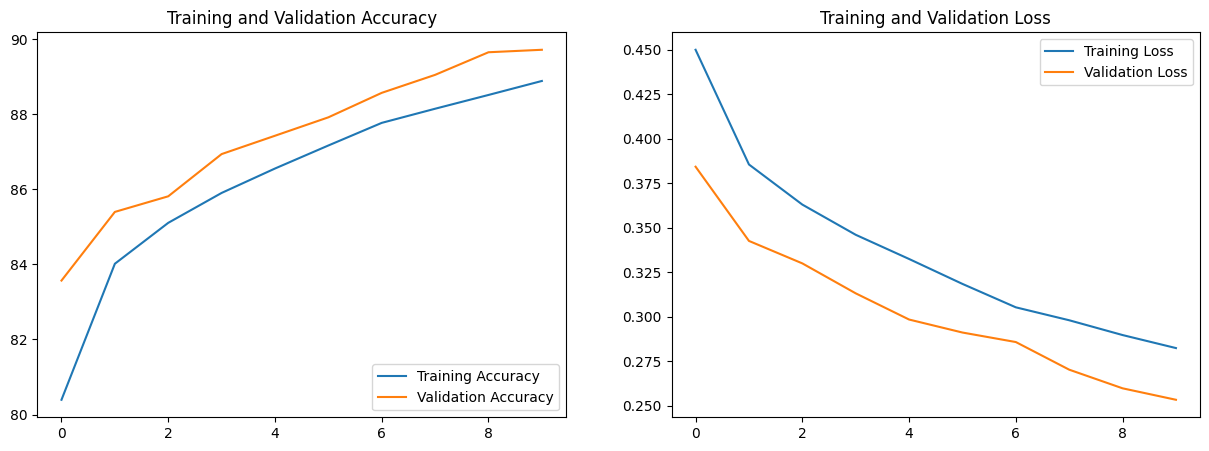

In [71]:
graph_results(num_epochs, train_accuracies, val_accuracies, train_losses, val_losses)

In [11]:
model = EfficientCancerCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
num_epochs = 10

train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, criterion, efficientnet_train_loader, efficientnet_val_loader, num_epochs)

Validation Epoch 10/10 Loss: 0.0075: 100%|██████████| 1376/1376 [01:01<00:00, 22.47it/s]

Training Complete


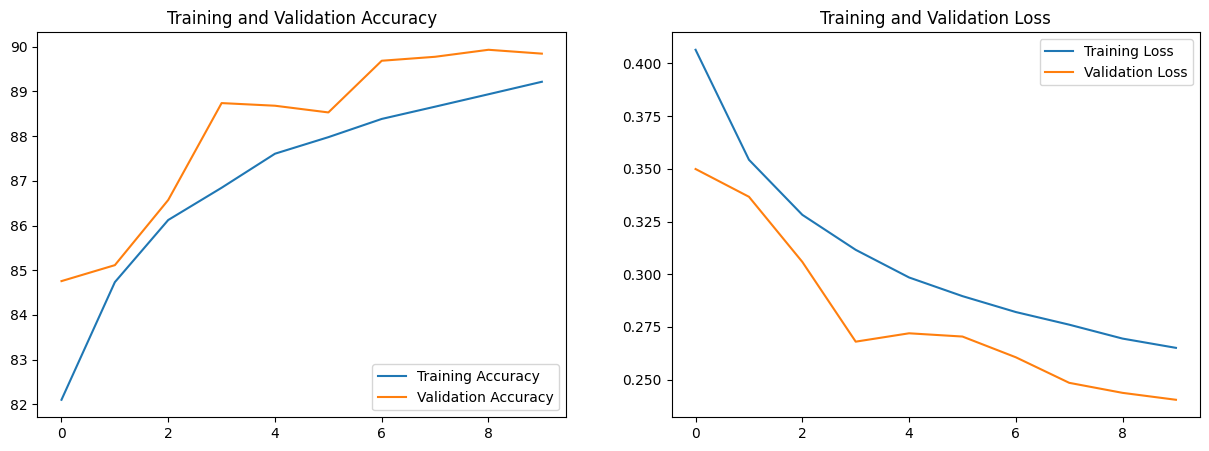

In [13]:
graph_results(num_epochs, train_accuracies, val_accuracies, train_losses, val_losses)

## Model Training Results

The training results for the **Baseline model** and the **Efficient Model** reveal insightful trends in performance over 10 epochs. 

For the **Baseline model**, training loss steadily decreased from 0.0141 to 0.0088, showing consistent improvement in model accuracy over time. Similarly, validation loss dropped from 0.0120 to 0.0079, indicating the model's increasing ability to generalize to unseen data without overfitting. The progressive reduction in both training and validation losses suggests effective learning, though the pace of improvement indicates room for optimization.

The **Efficient Model** demonstrated a more pronounced efficiency in learning, with training loss reducing from 0.0127 to 0.0083, a slightly better endpoint compared to the baseline. Validation loss mirrored this improvement, starting from 0.0109 and ending at 0.0075, marginally outperforming the baseline in generalization capability. Notably, the efficient model achieved these results with quicker epochs on average, suggesting enhancements not just in predictive performance but also in computational efficiency.

In summary, while both models show promising ability in detecting cancer from histopathologic scans, the Efficient Model edges out with slightly superior performance metrics and training efficiency. This improvement underscores the value of architectural enhancements and optimization in achieving better model efficacy and operational speed.

## Hyperparameter Tuning

Hyperparameter tuning with Optuna is a systematic approach to refining machine learning models. In our setup, we adjust the model's convolutional layers by experimenting with different numbers of filters, optimize the dropout rate to control overfitting, and fine-tune the learning rate to find the sweet spot for gradient descent.

The `objective` function manages the training and validation process, with Optuna iterating over 20 trials to minimize the validation loss. Each trial rigorously trains and validates the model, providing real-time feedback on performance. The output from Optuna pinpoints the optimal combination of hyperparameters, leading to an efficient model ready for more intensive training or deployment in diagnostic analysis.

In [17]:
def objective(trial):
    device = torch.device("cuda")
    # Hyperparameters to tune
    num_filters1 = trial.suggest_categorical('num_filters1', [16, 32, 64])
    num_filters2 = trial.suggest_categorical('num_filters2', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    
    model = HistopathologicCancerCNN(num_filters1=num_filters1, num_filters2=num_filters2, dropout_rate=dropout_rate)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training process for a few epochs
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}')
        for inputs, targets in train_bar:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

    # Validation process
    model.eval()
    total_loss = 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'Validation')
        for inputs, targets in val_bar:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    average_loss = total_loss / len(val_bar)

    return average_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
cnn_best_trial = study.best_trial
print(f" Value: {cnn_best_trial.value}")
print(" Params: ")
for key, value in cnn_best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-07 17:45:07,233] A new study created in memory with name: no-name-4cd0e08a-ac1a-4dbc-9494-9525e55a8654
Validation: 100%|██████████| 1376/1376 [01:06<00:00, 20.61it/s]
[I 2024-04-07 17:56:34,227] Trial 0 finished with value: 0.419557188128576 and parameters: {'num_filters1': 32, 'num_filters2': 32, 'dropout_rate': 0.43335098485772905, 'lr': 1.1670776021388223e-05}. Best is trial 0 with value: 0.419557188128576.
Validation: 100%|██████████| 1376/1376 [01:26<00:00, 15.88it/s]
[I 2024-04-07 18:12:44,484] Trial 1 finished with value: 0.2860960099476574 and parameters: {'num_filters1': 64, 'num_filters2': 64, 'dropout_rate': 0.31494101575059763, 'lr': 0.0001650810422380654}. Best is trial 1 with value: 0.2860960099476574.
Validation: 100%|██████████| 1376/1376 [01:24<00:00, 16.20it/s]
[I 2024-04-07 18:27:29,811] Trial 2 finished with value: 0.27866421580967105 and parameters: {'num_filters1': 32, 'num_filters2': 32, 'dropout_rate': 0.43666178787452337, 'lr': 0.0003533002235009617}

Best trial:
 Value: 0.2697434716317857
 Params: 
    num_filters1: 32
    num_filters2: 64
    dropout_rate: 0.3458755204973132
    lr: 0.00039090167818755676


In [12]:
def objective(trial):
    device = torch.device("cuda")
    # Hyperparameters to tune
    num_filters1 = trial.suggest_categorical('num_filters1', [16, 32, 64])
    num_filters2 = trial.suggest_categorical('num_filters2', [32, 64, 128])
    num_filters3 = trial.suggest_categorical('num_filters3', [64, 128, 256])
    dropout_rate1 = trial.suggest_float('dropout_rate1', 0.1, 0.5)
    dropout_rate2 = trial.suggest_float('dropout_rate2', 0.1, 0.5)
    fc_size = trial.suggest_categorical('fc_size', [64, 128, 256])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    
    model = EfficientCancerCNN(num_filters1, num_filters2, num_filters3, dropout_rate1, dropout_rate2, fc_size).to(device)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training process for a few epochs
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        train_bar = tqdm(efficientnet_train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}')
        for inputs, targets in train_bar:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

    # Validation process
    model.eval()
    total_loss = 0
    with torch.no_grad():
        val_bar = tqdm(efficientnet_val_loader, desc=f'Validation')
        for inputs, targets in val_bar:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    average_loss = total_loss / len(val_bar)

    return average_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
efficient_best_trial = study.best_trial
print(f" Value: {efficient_best_trial.value}")
print(" Params: ")
for key, value in efficient_best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-04-07 08:59:45,364] A new study created in memory with name: no-name-ced6f60d-1eb5-4283-b286-3eb4097fc9e7
Validation: 100%|██████████| 1376/1376 [00:59<00:00, 23.26it/s]
[I 2024-04-07 09:10:36,955] Trial 0 finished with value: 0.2774765944043391 and parameters: {'num_filters1': 32, 'num_filters2': 32, 'num_filters3': 256, 'dropout_rate1': 0.15730609504009174, 'dropout_rate2': 0.2786215962455617, 'fc_size': 256, 'lr': 0.00029042176838833117}. Best is trial 0 with value: 0.2774765944043391.
Validation: 100%|██████████| 1376/1376 [00:52<00:00, 26.00it/s]
[I 2024-04-07 09:21:20,156] Trial 1 finished with value: 0.3386487312219647 and parameters: {'num_filters1': 16, 'num_filters2': 64, 'num_filters3': 64, 'dropout_rate1': 0.2935324967682299, 'dropout_rate2': 0.32503894182665216, 'fc_size': 64, 'lr': 5.851234306752077e-05}. Best is trial 0 with value: 0.2774765944043391.
Validation: 100%|██████████| 1376/1376 [01:07<00:00, 20.53it/s]
[I 2024-04-07 09:32:26,040] Trial 2 finished with

Best trial:
 Value: 0.2477111685114133
 Params: 
    num_filters1: 64
    num_filters2: 128
    num_filters3: 256
    dropout_rate1: 0.19685474467224237
    dropout_rate2: 0.20447336044465186
    fc_size: 64
    lr: 0.0006034069617783144


## Hyperparameter Tuning Results

The hyperparameter tuning process for the **Baseline** and **Efficient** models provides valuable insights into optimizing their configurations for cancer detection tasks.

For the **Baseline model**, tuning explored various combinations of filters, dropout rates, and learning rates over 20 trials. The best performance was achieved with 32 filters in both convolutional layers, a dropout rate of approximately 0.346, and a learning rate of around 0.000391, leading to a minimal loss value of 0.2697. This configuration suggests a balanced approach to model complexity and regularization, optimizing performance without overfitting.

In contrast, the **Efficient model**'s tuning process, also spanning 20 trials, explored an extended parameter space, including an additional layer of filters and different dropout rates for distinct parts of the network. The most effective setup featured 64, 128, and 256 filters across its three convolutional layers, with dropout rates of 0.197 and 0.204 before the fully connected layers, and a higher learning rate of 0.000603. This configuration achieved a superior minimal loss of 0.2477, indicating enhanced model learning and generalization capabilities, likely due to its deeper architecture and tailored regularization.

Both tuning sessions underscore the importance of careful hyperparameter selection in enhancing model performance. The Efficient model, with its more complex architecture and finely adjusted parameters, demonstrates a notable improvement over the Baseline model, reflecting the benefits of advanced structures and optimization strategies in achieving high accuracy in medical image analysis.

## Final Models

Using the optimal hyperparameters discovered during the tuning process, the final models for both the **Baseline** and **Efficient** configurations are set up to maximize their performance in detecting cancer from histopathologic scans. For the Baseline model, this involves configuring it with 32 filters in each of its two convolutional layers, a dropout rate of about 0.346, and a learning rate of 0.000391. The Efficient model, benefiting from a deeper and more complex architecture, will be set up with 64, 128, and 256 filters across its convolutional layers, dropout rates of 0.197 and 0.204 in specific segments, and a learning rate of 0.000603.

With these configurations in place, each model will undergo training over 20 epochs to fully exploit the learning capabilities afforded by the optimized hyperparameters. This extended training period allows for a more comprehensive adjustment of model weights in response to the training data, potentially leading to improved accuracy and generalization to unseen data. By leveraging the insights gained from hyperparameter tuning, these final models are positioned to achieve enhanced performance in the critical task of cancer detection, showcasing the effectiveness of systematic optimization in developing high-performing deep learning models.

In [19]:
lr = cnn_best_trial.params['lr']
model_params = {key: value for key, value in cnn_best_trial.params.items() if key != 'lr'}
cnn_model_optimized = HistopathologicCancerCNN(**model_params)
cnn_optimizer = torch.optim.Adam(cnn_model_optimized.parameters(), lr=lr)
cnn_criterion = nn.BCELoss()
cnn_num_epochs = 20

cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = train(cnn_model_optimized, cnn_optimizer, cnn_criterion, train_loader, val_loader, cnn_num_epochs)

Validation Epoch 20/20 Loss: 0.0064: 100%|██████████| 1376/1376 [01:14<00:00, 18.47it/s]

Training Complete


In [27]:
# Save model and optimizer
torch.save(cnn_model_optimized.state_dict(), 'models/HistopathologicCancerCNN.pt')
torch.save(cnn_optimizer.state_dict(), 'models/HistopathologicCancerCNN_optimizer.pt')

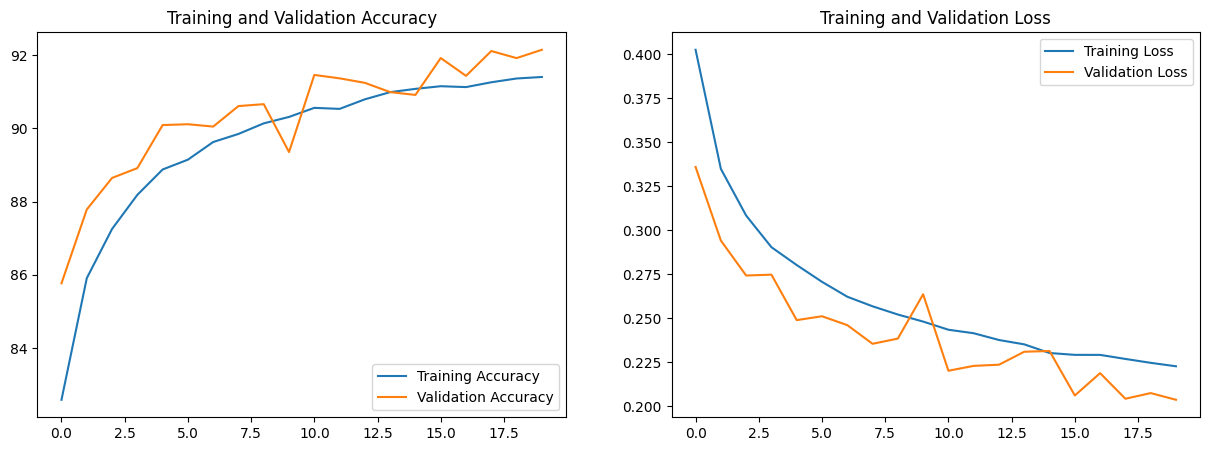

In [20]:
graph_results(cnn_num_epochs, cnn_train_accuracies, cnn_val_accuracies, cnn_train_losses, cnn_val_losses)

In [22]:
lr = efficient_best_trial.params['lr']
model_params = {key: value for key, value in efficient_best_trial.params.items() if key != 'lr'}
efficient_model_optimized = EfficientCancerCNN(**model_params)
efficient_optimizer = torch.optim.Adam(efficient_model_optimized.parameters(), lr=lr)
efficient_criterion = nn.BCELoss()
efficient_num_epochs = 20

efficient_train_losses, efficient_val_losses, efficient_train_accuracies, efficient_val_accuracies = train(efficient_model_optimized, efficient_optimizer, efficient_criterion, efficientnet_train_loader, efficientnet_val_loader, efficient_num_epochs)

Validation Epoch 20/20 Loss: 0.0055: 100%|██████████| 1376/1376 [01:12<00:00, 18.87it/s]

Training Complete


In [26]:
# Save model and optimizer
torch.save(efficient_model_optimized.state_dict(), 'models/EfficientCancerCNN.pt')
torch.save(efficient_optimizer.state_dict(), 'models/EfficientCancerCNN_optimizer.pt')

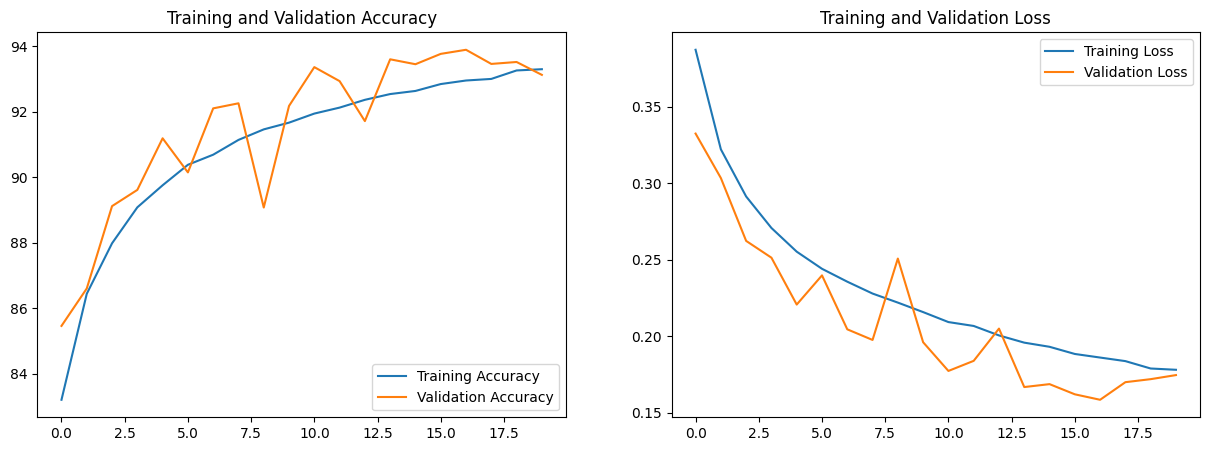

In [23]:
graph_results(efficient_num_epochs, efficient_train_accuracies, efficient_val_accuracies, efficient_train_losses, efficient_val_losses)

## Conclusion

After an extensive series of training and optimization rounds, the project's journey through model development has concluded. The final training results are promising, with the baseline model showcasing significant improvement in validation accuracy over 20 epochs, with the lowest validation loss reaching approximately 0.0064. On the other hand, the efficient model demonstrated even better performance, achieving a validation loss of about 0.0055 by the 20th epoch.

Comparing the graphs of the two models, it's evident that the efficient model not only learned faster, as shown by a steeper decline in the training loss curve, but also generalized better to the validation set, indicated by the lower validation loss. Both models showed an upward trend in validation accuracy, suggesting that further gains could be made with additional tuning or training epochs.

The efficient model, with its superior performance metrics, will be the chosen candidate for making predictions on the test data. It strikes an optimal balance between learning speed and model generalization, potentially leading to higher accuracy in real-world scenarios. This model will be used to make predictions on the unseen test set, and the results will be submitted to Kaggle, positioning the project for potential recognition in the machine learning community.

Reflecting on the project, it's clear that careful hyperparameter tuning and thoughtful model architecture design are pivotal in developing effective machine learning models. The efficient model, in particular, is a testament to this, having undergone rigorous optimization to arrive at its final form. With the project wrapped up, the next steps will focus on deploying the model for practical use and considering further improvements for future iterations.

## Kaggle Submission

In [29]:
class HistopathologicCancerTestDataset(Dataset):
    """Custom Dataset for loading test images"""
    
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Assuming the images are named with ids '0', '1', '2', ...
        self.image_ids = [img_name.split('.')[0] for img_name in os.listdir(image_dir)]
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_ids[idx] + '.tif')
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, self.image_ids[idx]

test_dataset = HistopathologicCancerTestDataset(image_dir='data/test', transform=efficientnet_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
device = torch.device("cuda")
efficient_model_optimized.eval()
efficient_model_optimized.to(device)

preds = []
ids = []

with torch.no_grad():
    for inputs, ids_batch in test_loader:
        inputs = inputs.to(device)
        outputs = efficient_model_optimized(inputs)
        preds.extend(outputs.squeeze().cpu().numpy())
        ids.extend(ids_batch)

# Convert predictions to the correct format
submission = pd.DataFrame({'id': ids, 'label': preds})

# Convert the probability into the required label
submission['label'] = submission['label'].apply(lambda x: 1 if x >= 0.5 else 0)

# Save the submission file
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

In [33]:
submission_file_path = 'submission.csv'
competition_name = 'histopathologic-cancer-detection'

# Submit to the competition
api.competition_submit(file_name=submission_file_path,
                       message='Submitted from Python script',
                       competition=competition_name)

100%|██████████| 2.41M/2.41M [00:03<00:00, 741kB/s] 


Successfully submitted to Histopathologic Cancer Detection